# Feature Extractor

Creiamo un Feature Extractor (che restituisce le Feature Maps intermedie) utilizzando una rete neurale pre-addestrata (ResNet50V2) addestrata sul dataset ImageNet.

![alt text](../images/Illustration-of-ResNet-50V2-network-architecture.png)

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [3]:
# Step 1: carichiamo la rete preaddestrata
# include_top=False perchè escludiamo la parte finale della rete (layers di Flatten e Dense) che in questo caso non ci interessano
resnet_model = keras.applications.ResNet50V2(weights="imagenet", include_top=False)

# Step 2: Identificare i layer target
# ogni layer in una rete Keras ha un nome
# prendiamo un layer molto vicino all'input ed un layer molto più profondo
layer_names = ['conv2_block1_1_conv', 'conv5_block3_3_conv']

layers = [resnet_model.get_layer(name=layer_name) for layer_name in layer_names]
print("Layer selezioanti:", layers)

# Step 3: Creare il Feature Extractor
feature_extractor = keras.Model(
    inputs=resnet_model.inputs,
    outputs=[layer.output for layer in layers]
)

Layer selezioanti: [<Conv2D name=conv2_block1_1_conv, built=True>, <Conv2D name=conv5_block3_3_conv, built=True>]


## Utilizzo del Feature Extractor creato

Usiamo una immgine di esempio per estrarre le features maps dai rispettivi layers.

![alt text](../images/elephant.jpg)

In [4]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Carichiamo l'immagine d'esempio e la preprocessiamo

img_path = "../images/elephant.jpg"

img = load_img(img_path, target_size=(224, 224))
# trasforma l'immagine in un tensore
input_image = img_to_array(img)
# aggiungiamo una dimensione sull'asse 0 (per creare batch di immagini) in questo caso di una sola immagine
input_image = np.expand_dims(input_image, axis=0)
# trasforma l'immagine in modo che sia adatta per entrare (input) per questa rete neurale
input_image = preprocess_input(input_image)

# ora l'immagine è pronta per essere data in input all'FE (anche alla ResNet50V2)
# Estraiamo le features
features = feature_extractor(input_image)

# Visualizziamo le dimensioni delle attivazioni (feature maps) estratte
print("\nDimensioni delle attivazioni per ciascun layer selezionato:")
for i, feature_map in enumerate(features):
    print(f"Layer {layer_names[i]}: {feature_map.shape}")

c:\Users\felip\Desktop\MLMC\.venv\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)



Dimensioni delle attivazioni per ciascun layer selezionato:
Layer conv2_block1_1_conv: (1, 56, 56, 64)
Layer conv5_block3_3_conv: (1, 7, 7, 2048)


Dimensioni delle attivazioni per ciascun layer selezionato:

Layer conv2_block1_1_conv: (1, 56, 56, 64) -> 1 si riferisce alla dimensione del batch, ovvero alla singola immagine in questo caso. Ci sono 64 Feature Maps di dimensione 56x56.

Layer conv5_block3_3_conv: (1, 7, 7, 2048) -> Abbiamo 2048 Feature Maps di dimensione 7x7.

## Modello Originale ResNet50V2

Giusto per vedere la differenza tra il modello originale e la Feature Exctractor, utilizziamo la stessa immgine di input sul modello completo di anche dei livelli di flatten de dense.

In [ ]:
# Modello completo con la testa inclusa
full_model = keras.applications.ResNet50V2(weights="imagenet")
preds = full_model.predict(input_image)

# Visualizziamo la shape dell'output finale
print("\nShape dell'output finale del modello completo:", preds.shape)

# Decodifica delle predizioni finali (troviamo i nomi delle classi)
# passiamo le predizioni dicendo che ci interessano solo le prime 3 (con la probabilità più alta)
decoded_preds = keras.applications.resnet_v2.decode_predictions(preds, top=3)
print("\nPredizioni finali:")
for pred in decoded_preds[0]:
    print(f"{pred[1]}: {pred[2]*100:.2f}%")

102869336/102869336 ━━━━━━━━━━━━━━━━━━━━ 31s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Shape dell'output finale del modello completo: (1, 1000)

Predizioni finali:
African_elephant: 95.99%
tusker: 3.94%
Indian_elephant: 0.06%


### Il modello ResNet50V2 viene usato per riconoscere cose all'interno di una immagine e quidi classificarla

(1, 1000) -> 1 immagine data in input e 1000 punteggi di probabilità per ciasuna delle 1000 classi 

Predizioni finali:
African_elephant: 95.99%
tusker: 3.94%
Indian_elephant: 0.06%

## Visualizzazione di una Feature Map

Andiamo ora a vedere visivamente come sono fatte le feature maps di output dai livelli scelti nella Feature Extractor.

In [ ]:
print(features[0].shape)
print(features[0][0].shape)
# [0, :, :, 0] -> 0 relativa alla prima ed unica immagine, : : tutti i 56X56, 0 la prima feature map
print(features[0][0, :, :, 0])

(1, 56, 56, 64)
(56, 56, 64)
tf.Tensor(
[[-7.9019756 -7.881115  -7.488868  ... -7.228467  -7.2268085 -8.136119 ]
 [-7.1205425 -6.921922  -6.4179864 ... -6.04569   -6.045617  -7.912512 ]
 [-6.5523763 -6.113739  -6.0761237 ... -5.6896133 -5.2910504 -7.277855 ]
 ...
 [-5.8371105 -5.91575   -6.6751328 ... -5.142826  -5.264662  -6.380138 ]
 [-6.122655  -6.1323643 -5.7019844 ... -5.276195  -5.226691  -5.940929 ]
 [-5.7112703 -5.4836745 -5.031756  ... -5.380646  -5.308876  -5.7002516]], shape=(56, 56), dtype=float32)


Feature Map (elenco di numeri):
tf.Tensor(
[[-7.9019756 -7.881115  -7.488868  ... -7.228467  -7.2268085 -8.136119 ]
 [-7.1205425 -6.921922  -6.4179864 ... -6.04569   -6.045617  -7.912512 ]
 [-6.5523763 -6.113739  -6.0761237 ... -5.6896133 -5.2910504 -7.277855 ]
 ...
 [-5.8371105 -5.91575   -6.6751328 ... -5.142826  -5.264662  -6.380138 ]
 [-6.122655  -6.1323643 -5.7019844 ... -5.276195  -5.226691  -5.940929 ]
 [-5.7112703 -5.4836745 -5.031756  ... -5.380646  -5.308876  -5.7002516]], shape=(56, 56), dtype=float32)


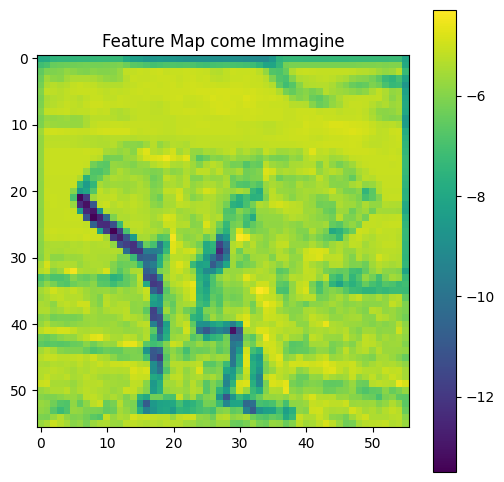

In [ ]:
# Le features sono i due output dei due livelli scelti
import matplotlib.pyplot as plt

# Selezioniamo una feature map specifica dal primo layer target (64 FM di 56x56)
# 
feature_map = features[0][0, :, :, 0] # prima fature map del primo layer

# 1. Visualizziamo la feature map come lenco di numeri
print("Feature Map (elenco di numeri):")
print(feature_map)

# 2. Visualizziamo la feature map come immagine
plt.figure(figsize=(6, 6))
# prendi i numeri della FM e trasportali all'interno del range (0, 255)
plt.imshow(feature_map, cmap="viridis")
plt.title("Feature Map come Immagine")
plt.colorbar()
plt.show()

Da quel che vediamo possiamo dire che i filtri usati per ottenere questa Feature Map sono bravi nel rilevare i bordi sinistri dell'immagine.

Feature Map (elenco di numeri):
tf.Tensor(
[[-2.7923    -1.853637  -2.4098165 ... -2.4654279 -2.4667573 -2.2420757]
 [-3.7027113 -2.024346  -2.5180738 ... -2.576651  -2.5832982 -2.3494565]
 [-3.542168  -1.8845397 -2.3275945 ... -2.429143  -2.6030688 -2.311829 ]
 ...
 [-3.0675478 -2.7196023 -2.2374775 ... -3.2497492 -3.2492683 -2.8276718]
 [-2.9328551 -3.5857112 -3.9704273 ... -3.2056568 -3.408061  -2.9878619]
 [-2.7081137 -3.2586508 -3.6309574 ... -3.5224621 -3.139048  -3.3915625]], shape=(56, 56), dtype=float32)


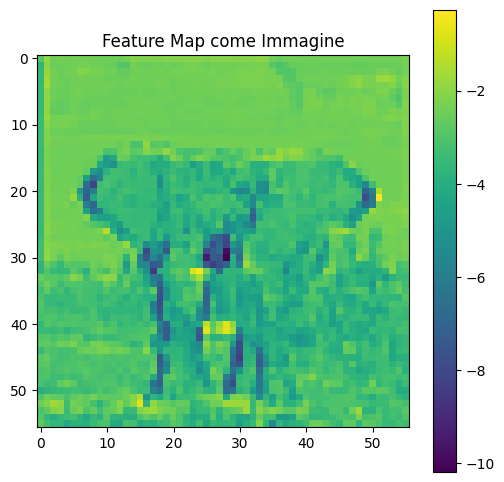

In [20]:
feature_map = features[0][0, :, :, 63] # ultima fature map del primo layer

# 1. Visualizziamo la feature map come lenco di numeri
print("Feature Map (elenco di numeri):")
print(feature_map)

# 2. Visualizziamo la feature map come immagine
plt.figure(figsize=(6, 6))
# prendi i numeri della FM e trasportali all'interno del range (0, 255)
plt.imshow(feature_map, cmap="viridis")
plt.title("Feature Map come Immagine")
plt.colorbar()
plt.show()